# Support Vector Machine (SVM) Model 
<p style="text-align: justify;">While, SARIMA has a realistic confidence interval and unbiased forecasts, it has strong restriction and assumption, poor efficiency when the relationship is non linear, and it is hard to automate the process.
<br/>Time series prediction is going to be an important area of machine learning. Support vector machine (SVM) method is a popular tool for regression.
<br/>Before analysis of time series using machine learning, we need to re-structure the data to look like a supervised learning problem as there is no concept of input and output features. The main issue is that the inherent relationship between input and output is not clear. Anyway, if it was determined then we do not need any machine learning tools. We are only able to evaluate the resulted model and check the accuracy.     

## Re-structure the Dataset
Time is one of the most challenging concepts in the Universe._Julian Barbour_, a British physicist with research interests in quantum gravity stated: 
**<p style="text-align: center;">"The Universe is really a vast, static array of ‘nows’, like frames on some cosmic movie-reel. At any given moment, or ‘now’, time does not need to be factored into explanations of how the Universe works"**  <br/>

<p style="text-align: justify;"><br/>So, the definition of time comes from our minds processing each of these frames which means that time doesn’t exist! The concept might be useful to re-structure the time series and introduced as a supervised learning problem.

<br/>The data can not be directly used in supervised ML because probably you will get an over-fitted model. They could not consider the relationship that exist between observation and it should be take into account explicitly.
<br/>
<br/>During re-format, the sequence of time series (ordered by a time index) could be restructured to a data set that supervised machine learning typically used.Regression models prefer uncorrelated input variables for model stability. But this not a requirement. _Sliding Window_ method uses previous time steps values as features and the next step value as target (Below Figure). This has a benefit of preservation of the order in time series structure.

<img src="Figures/SlidingWindow.JPG" height="900" width="800">

## Transformation
In order to simplify the prediction problem, we might need a transformation. In the following, three popular methods will be reviewed. It is good practice to test the result with and without these transformation.  
* Power transform such as log make the distribution more normal. It removes the change in variance over time.   
* Differencing can be used to remove trend and seasonal structure from the sequence in order to simplify the problem.  
* Some ML algorithms prefer data to be normalized prior to modeling. Normalization can be used to re-scale data to a new range such as MinMaxScaler.  

It should be noted that any transform operations applied to the series also require a similar inverse transform to be applied on the predictions.

## Train-Test split 
<p style="text-align: justify;">Because of relationship between the observations, conventional train-test splits and k-fold cross validation, can not be applied. In other words, we cannot randomly split them into groups. Instead, and in order to prevent data leakage we must split data up and respect the time order in which values were observed.<br/>We can also use multiple Train-Test splits instead of regular cross validation (Below figure).
<img src="Figures/Split.JPG" height="600" width="450">

Let's start modeling of Energy consumption using SVM.

# Hourly Energy Consumption Modeling using SVM

In this section we will use SVM model to model our data set. First we import required libraries to analysis the time series.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.filterwarnings('ignore')

<p style="text-align: justify;">In the following, the data set is imported and the original observation values and re-sampled data will be plotted. Daily re-sampling is used in the modeling of data using SVM. 

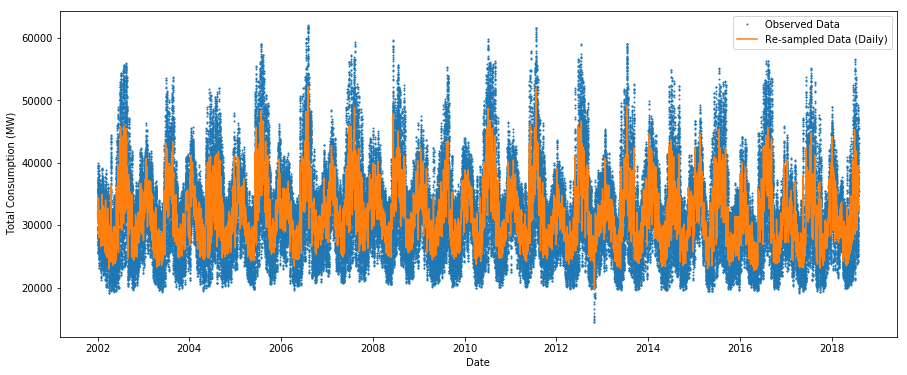

In [9]:
# Import data
df = pd.read_csv("Sources\EastTotalConsumption.csv", header=1, skiprows=None, parse_dates=[0], names=['datetime', 'totalconsum'])

# Re-sampling (Daily)
df_re=df.reset_index().set_index('datetime')
df_re.index = pd.to_datetime(df_re.index)
df_re=df_re.resample('d').mean()

# Plot observations and re-sampled data 
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime), df.totalconsum,'o',markersize=1)
plt.plot(df_re.index, df_re.totalconsum,'-',markersize=1, label="Train")
plt.xlabel('Date')
plt.ylabel('Total Consumption (MW)')
plt.legend(['Observed Data', "Re-sampled Data (Daily)"])
plt.show()
df_re["datetime"]=df_re.index
df_re.drop(columns="index",inplace=True)
df_re.reset_index(drop=True, inplace=True)
df=df_re

In the next step, we will split data to Training and Test sets, and plot.

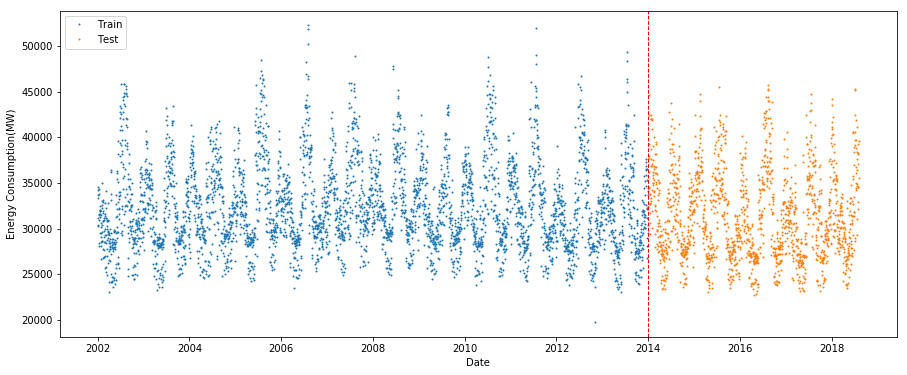

In [10]:
# Split Dataset: 70% Training and 30% Test 
train_range = df[df.datetime < '2014-01-01'].index
test_range = df[df.datetime >= '2014-01-01'].index

# Plot Training and Test sets:
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime)[train_range], df.totalconsum[train_range],'o',markersize=1, label="Train")
plt.plot(pd.to_datetime(df.datetime)[test_range], df.totalconsum[test_range],'o',markersize=1, label="Test")
plt.axvline(pd.to_datetime(df.datetime)[test_range[0]], c='red', ls='--', lw=1)
plt.legend(loc='upper left')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')
plt.show()

<p style="text-align: justify;">SVMs assume that the data is in a standard range, usually between 0  and 1. So, the normalization of feature vectors prior to feeding them to the SVM is very important.

In [11]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
yScaled = scaler.fit_transform( df.totalconsum.astype(float).values.reshape(-1, 1));

In the nest step and as we have discussed before, time series data will be converted to a data set that can be used in SVM method.

In [12]:
# Sliding Window method to generate feature
def generateFeatures(yScaled,trainR,testR, season):
    X_train = np.empty(shape=(0, season)); X_test = X_train
    y_train = np.array([]) ; y_test = y_train

    for i in range(season, yScaled.shape[0]):
        X = yScaled[i - season:i].reshape(1, -1)
        y = yScaled[i].reshape(-1, )
        if i in trainR:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.append(y_train, y)
        elif i in testR:
            X_test = np.concatenate((X_test, X), axis=0)
            y_test = np.append(y_test, y)

    return X_train, y_train, X_test, y_test

# Applay the generateFeatures method to the 
season = 365
X_train, y_train, X_test, y_test = generateFeatures(yScaled,train_range, test_range, season)

As we are going to Grid Search method, it is needed to define Time Series Cross Validation  using `TimeSeriesSplit`.

Train-Test No 1
Total Samples: 1342
Training Samples: 673
Testing Samples: 669

Train-Test No 2
Total Samples: 2011
Training Samples: 1342
Testing Samples: 669

Train-Test No 3
Total Samples: 2680
Training Samples: 2011
Testing Samples: 669

Train-Test No 4
Total Samples: 3349
Training Samples: 2680
Testing Samples: 669

Train-Test No 5
Total Samples: 4018
Training Samples: 3349
Testing Samples: 669



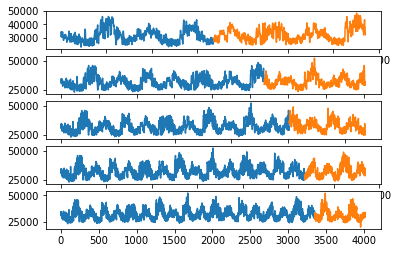

In [13]:
# Generate split points using TimeSeriesSplit function
splits = TimeSeriesSplit(n_splits=5)

#Plot multi Training-Test sets
plt.figure(1)
index = 1
for train_index, test_index in splits.split(X_train):
	train = df.totalconsum[train_index]
	test = df.totalconsum[test_index]
	print('Train-Test No',index)
	print('Total Samples: %d' % (len(train) + len(test)))
	print('Training Samples: %d' % (len(train)))
	print('Testing Samples: %d\n' % (len(test)))
	plt.subplot(510 + index)
	plt.plot(train)
	plt.plot([None for i in train] + [x for x in test])
	index += 1
plt.show()

<p style="text-align: justify;">Now, we are able to model the data set using Grid Search method. We will specify the ranges for SVM parameters and Generate cross validation data using `TimeSeriesSplit`. Radial Basis Function (RBF) is used as a Kernel function.

In [14]:
# SVM Parameters ranges:
C_range = np.logspace(-6, 6, 13)
gamma_range = np.logspace(-6, 6, 13)
param_grid = {"gamma": gamma_range,"C": C_range}

# Time series cross validation
cv=TimeSeriesSplit(n_splits=5).split(X_train)

# Kernel: Radial Basis Function (RBF), No of Jobs=7
grid = GridSearchCV(svm.SVR(kernel="rbf"), param_grid=param_grid, cv=cv, n_jobs=7, verbose=10, refit=True)
grid.fit(X_train, y_train)

model = grid.best_estimator_
print("Optimum parameters: {} & Score: {:0.3f}".format(grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   21.3s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   28.0s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   36.1s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   43.9s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   54.4s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.3min
[Parallel(

Optimum parameters: {'C': 100000.0, 'gamma': 1e-06} & Score: 0.746


After model generation, the model is evaluated. The R2 is 0.75.

To see how model parameters effect on the model, `mean_test_score` is used as the objective function to generate the heat map.

In [15]:
# Report model mean_test_score & std_test_score values
scores_mean = grid.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(gamma_range),len(C_range))

scores_sd = grid.cv_results_['std_test_score']
scores_sd = np.array(scores_sd).reshape(len(gamma_range),len(C_range))

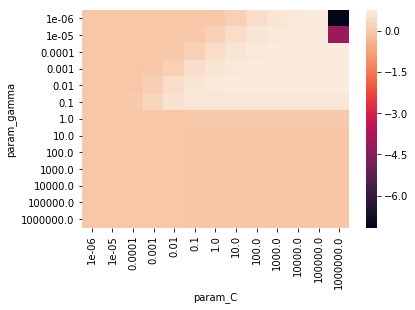

In [16]:
# Generate Heatmap plot to see the effects of model parameter on mean test score.
pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_test_score', index='param_gamma', columns='param_C')
ax = sns.heatmap(pvt)

## Model Validation
In the following we will use generated model to forecast.

In [17]:
# Forecast
yh_tr = model.predict(X_train)
yh_te = model.predict(X_test)

Values are predicted for both Train and test sets in the scaled format. we will unscale them to the original range.

In [18]:
# Unscaling predicted results (Train and Test sets)
yh_tr_uns = scaler.inverse_transform(yh_tr.reshape(-1,1)).flatten()
yh_te_uns = scaler.inverse_transform(yh_te.reshape(-1,1)).flatten()

# Unscaling Observed data
y_tr_uns = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_te_uns = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

In the following we can compare the predicted values with the observed data visually.

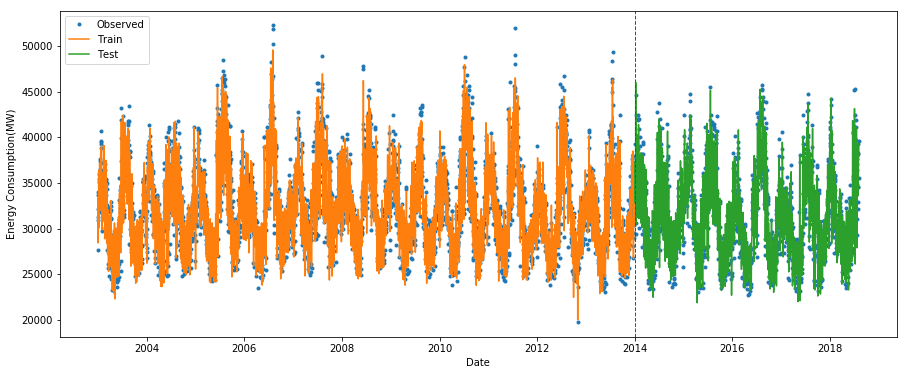

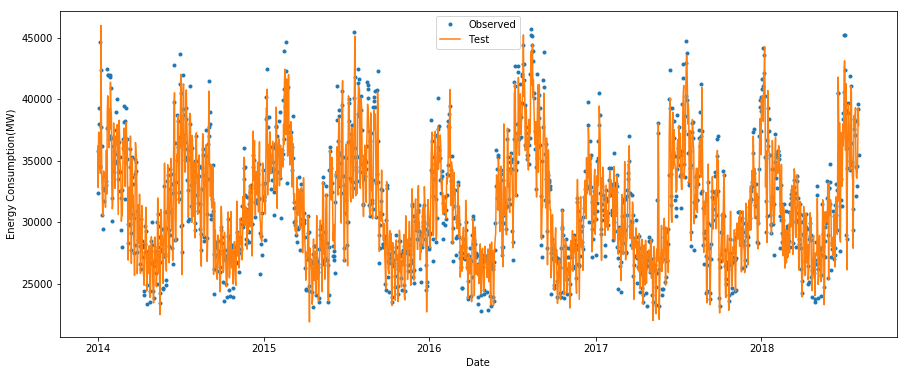

In [19]:
# Plot Observed data, unscaled predicted Training & Test sets
plt.figure(figsize=(15,6))

# Plot observed values
plt.plot(pd.to_datetime(df.datetime)[season:], df.totalconsum[season:],'.', label="Observed")

# Plot predicted values for Train and Test sets
plt.plot(pd.to_datetime(df.datetime)[train_range][season:], yh_tr_uns ,'-',label="Train")
plt.plot(pd.to_datetime(df.datetime)[test_range], yh_te_uns,'-', label="Test")

plt.axvline(pd.to_datetime(df.datetime)[test_range[0]], c='red', ls='--', lw=1)

plt.legend(loc='upper left')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')
plt.show()

# Plot Unscaled observed and predicted values (Test set Only)
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(pd.to_datetime(df.datetime)[test_range], df.totalconsum[test_range],'.', label="Observed")
plt.plot(pd.to_datetime(df.datetime)[test_range], yh_te_uns,'-',label="Test")
plt.legend(loc='best')
plt.ylabel('Energy Consumption(MW)')
plt.xlabel('Date')
plt.show();

Finally, the scores for test set are presented below.

In [22]:
# Evaluate TEST SET:
mae = mean_absolute_error(y_te_uns, yh_te_uns)
mse = mean_squared_error(y_te_uns, yh_te_uns)
r2 = r2_score(y_te_uns, yh_te_uns)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))




MAE (test): 1549
MSE (test): 4079724
R2  (test): 0.819


The Test R<sup>2</sup> using SVM method is 0.82. 